In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
import ObsModels
import fun

from FSC import GenerationContinuousObs as FSC_ContinuousObs
from FSC import InferenceContinuousObs as FSC_InferenceContinuousObs

import numba as nb
import pandas as pd

In [3]:
path = "../data/data_filtered"
df = pd.read_csv(path)

In [4]:
cell_indexes = np.unique(df["particle"])
cell_indexes.size

3485

In [7]:
actions = []
frames = []
observations = []

for cell_idx in cell_indexes:
    cell = df[df["particle"] == cell_idx]

    actions.append(cell["tumbling"].values)
    frames.append(cell["frame"].values)
    observations.append(cell["c_norm"].values)

NCutStart = 0
NCutEnd = 500

actions = [actions[i] for i in range(NCutStart, NCutEnd)]
frames = [frames[i] for i in range(NCutStart, NCutEnd)]
observations = [observations[i] for i in range(NCutStart, NCutEnd)]

In [8]:
trajectories = []

for i in range(NCutEnd - NCutStart):
    dict_traj = {}
    dict_traj["actions"] = actions[i].astype(int)
    dict_traj["features"] = np.array([np.ones(observations[i].size).astype(np.float32), observations[i].astype(np.float32)])

    trajectories.append(dict_traj)

(array([73., 75., 69., 50., 37., 34., 27., 19., 23., 14.,  3.,  9., 11.,
         4.,  3.,  7.,  5.,  6.,  4., 27.]),
 array([ 266. ,  343.5,  421. ,  498.5,  576. ,  653.5,  731. ,  808.5,
         886. ,  963.5, 1041. , 1118.5, 1196. , 1273.5, 1351. , 1428.5,
        1506. , 1583.5, 1661. , 1738.5, 1816. ]),
 <BarContainer object of 20 artists>)

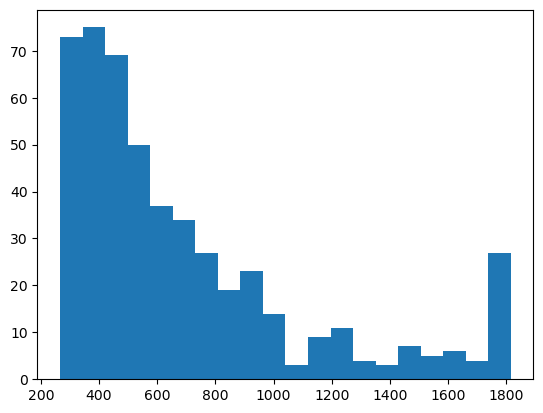

In [9]:
plt.hist([len(tr["actions"]) for tr in trajectories], bins=20)

In [10]:
F = 2
M = 3
A = 2

FSC_tofit = FSC_InferenceContinuousObs(M, A, F, seed = 123)
FSC_tofit.load_trajectories(trajectories)

In [ ]:
%%time
tloss, vloss = FSC_tofit.optimize(NEpochs = 10, NBatch = 50, lr = 0.05, gamma = 0.99)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 202.5919128417969, Validation loss: 142.36735370635986 - Learning rate: 0.05


In [95]:
FSC_inferred = FSC_ContinuousObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                                 FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 3 memory states, 2 actions, and 2 features.


In [96]:
FSC_inferred.load_features([trajectories[0]["features"]])

In [97]:
trajectories_inferred = FSC_inferred.generate_trajectories(400)
Time = np.arange(400)

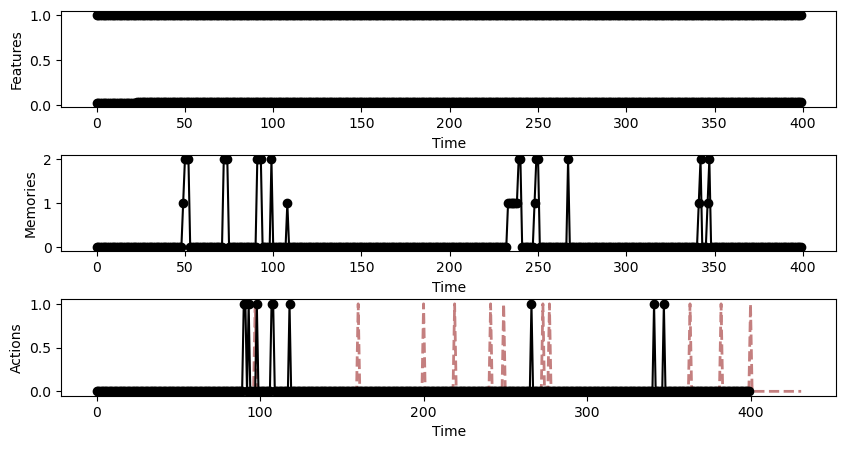

In [98]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

ax[2].plot(trajectories[idx_trj]["actions"], label = "True", color = "darkred", zorder = -1, alpha = 0.5, lw = 2, ls = "--")

[1.         0.01535034]


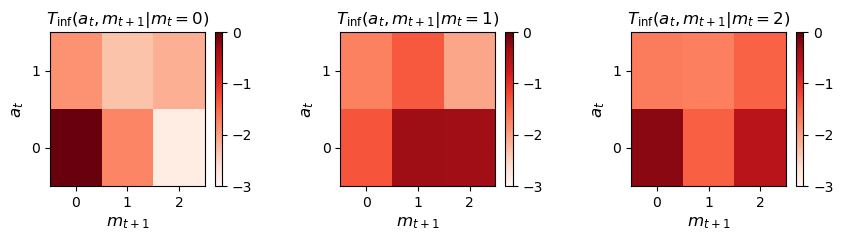

[1.         0.04841253]


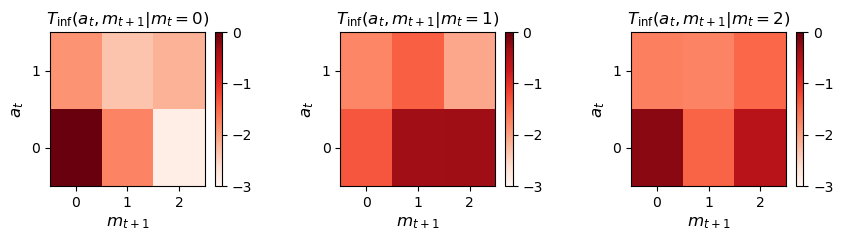

[1.         0.01381363]


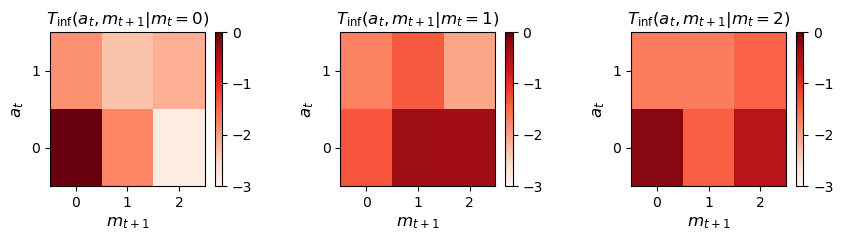

[1.         0.02615729]


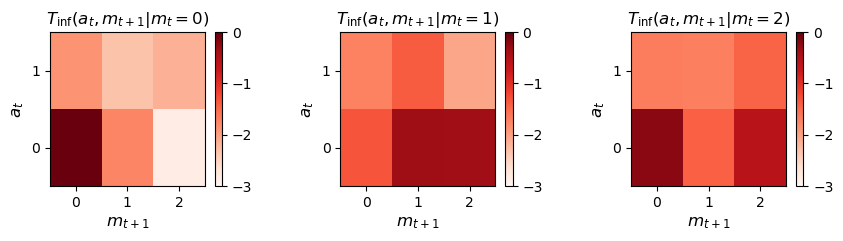

[1.         0.03146666]


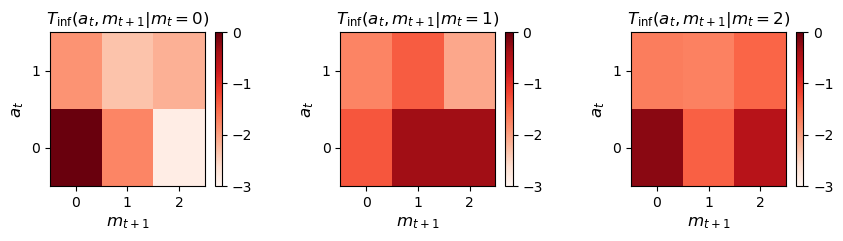

In [105]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20
for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    print(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, np.log10(TMat_inf[idx_m].T), vmin = -3, vmax = 0, cmap = "Reds")

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

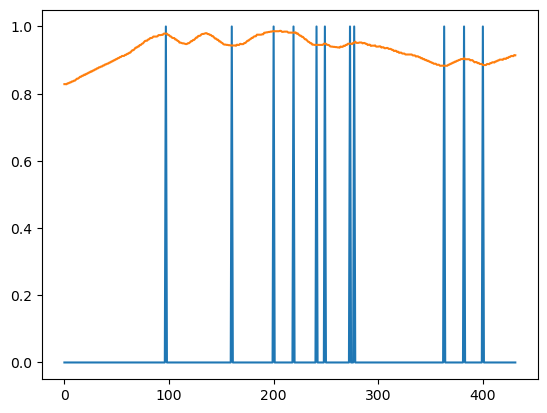

In [23]:
plt.plot(actions[0])
plt.plot(observations[0]*30)